In [1]:
path = "C:/Machine_learning_datafiles/DSN/Expresso Churn"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import  numpy as np
import pandas as pd
import random
import seaborn as sns

In [4]:
import catboost as cat
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, plot_confusion_matrix, plot_roc_curve

In [31]:
%matplotlib inline
pd.set_option('display.max_columns', 150)
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.size'] = 12
pd.set_option('display.max_colwidth', 2000)

In [6]:
train = pd.read_csv(path+'/Train.csv')
test = pd.read_csv(path+'/Test.csv')
subfile = pd.read_csv(path+'/sample_submission.csv')
vardefs = pd.read_csv(path+'/VariableDefinitions.csv')

In [7]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [8]:
vardefs

,Variable Definitions,Unnamed: 1,Unnamed: 2
0,NaN,French,English
1,NaN,Le dataset churn comprend 19 variables dont 15 variables numeriques et 04 variables categoriques.,The churn dataset includes 19 variables including 15 numeric variables and 04 categorical variables.
2,user_id,NaN,NaN
3,REGION,la localité de chaque client,the location of each client
4,TENURE,la durée dans le reseau,duration in the network
5,MONTANT,montant de recharge,top-up amount
6,FREQUENCE_RECH,nombre de fois que le client a fait une recharge,number of times the customer refilled
7,REVENUE,revenu mensuel de chaque client,monthly income of each client
8,ARPU_SEGMENT,revenu sur 90 jours/3,income over 90 days / 3
9,FREQUENCE,nombre de fois que client à fait un revenu,number of times the client has made an income


In [9]:
test_id = test.user_id

In [10]:
train.skew()

MONTANT            3.914305
FREQUENCE_RECH     2.122098
REVENUE            3.684768
ARPU_SEGMENT       3.684781
FREQUENCE          1.776179
DATA_VOLUME       27.727228
ON_NET             8.513781
ORANGE             7.225839
TIGO              11.539107
ZONE1             15.985402
ZONE2             14.310807
REGULARITY         0.247978
FREQ_TOP_PACK      4.205884
CHURN              1.604571
dtype: float64

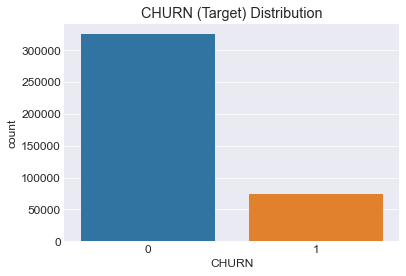

In [32]:
sns.countplot(train.CHURN)
plt.title('CHURN (Target) Distribution');

In [50]:
train.isna().sum()/train.shape[0]

user_id           0.000000
REGION            0.393800
TENURE            0.000000
MONTANT           0.350693
FREQUENCE_RECH    0.350693
REVENUE           0.336657
ARPU_SEGMENT      0.336657
FREQUENCE         0.336657
DATA_VOLUME       0.492135
ON_NET            0.364548
ORANGE            0.415793
TIGO              0.598465
ZONE1             0.920775
ZONE2             0.936218
MRG               0.000000
REGULARITY        0.000000
TOP_PACK          0.418322
FREQ_TOP_PACK     0.418322
CHURN             0.000000
dtype: float64

As we can see the train data has a lot of missing values, and filling in these values with the mean, median or mode could add some noise to the data, hence I resorted to not filling them with an arbitrarily high value (-999).

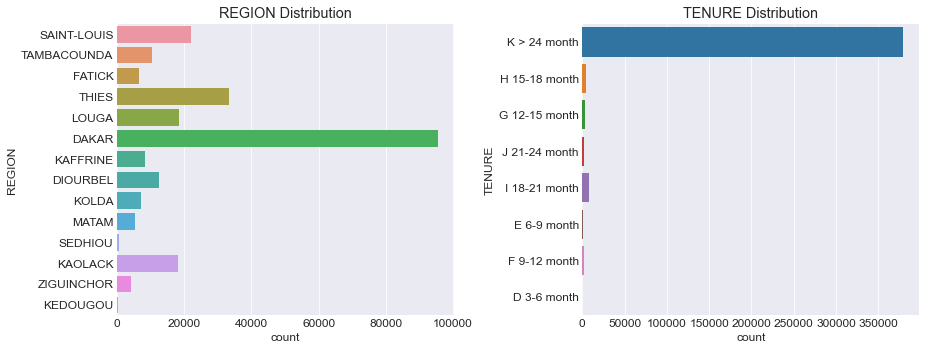

In [33]:
plt.figure(figsize=(13,5))
for i,col in enumerate(['REGION', 'TENURE'], start=1):
    plt.subplot(1,2, i)
    sns.countplot(y=train[col])
    plt.title(col + ' Distribution')
    plt.xticks()
plt.tight_layout(pad=1.);

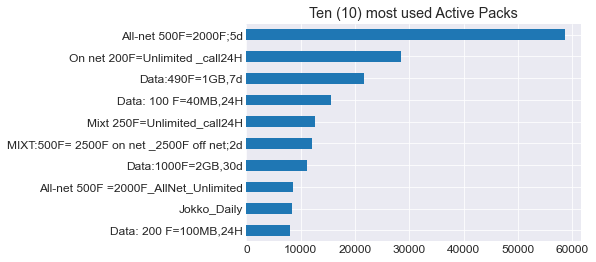

In [41]:
train.TOP_PACK.value_counts()[:10].sort_values().plot.barh(title='Ten (10) most used Active Packs');

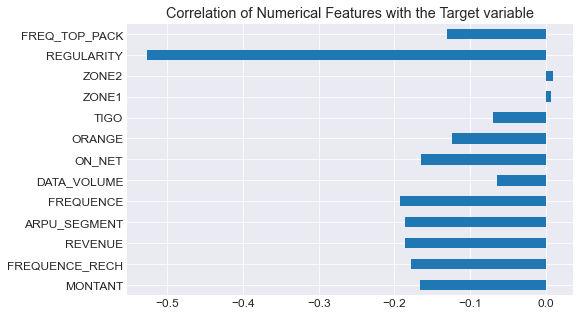

In [46]:
train.corr('spearman')['CHURN'][:-1].plot.barh(figsize=(8,5), 
                                          title='Correlation of Numerical Features with the Target variable');

Only Zones 1 and 2 are postitvely(weakly) correlated with the Target, while others are negatively correlated.

From the baseline model I found out that REGULARITY is one of the important features so I created combinations of it from other features.

#### Feature Engineering

In [11]:
df = train.append(test)[train.columns]

In [12]:
df['Total_Calls'] = df[['ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2']].sum(axis=1)

In [13]:
adds = pd.DataFrame()
adds['Income_Rech_Freq'] = df.FREQUENCE / df.FREQUENCE_RECH
adds['Income_Active_freq'] = df.FREQUENCE / df.REGULARITY
adds['Refill_Active_freq'] = df.FREQUENCE_RECH / df.REGULARITY

In [14]:
df = pd.concat([df, adds], 1)

In [15]:
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,Total_Calls,Income_Rech_Freq,Income_Active_freq,Refill_Active_freq
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0.0,458.0,1.062500,0.548387,0.516129
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0.0,13.0,1.275862,0.925000,0.725000
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0.0,60.0,1.000000,0.093750,0.093750
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0.0,223.0,1.333333,0.222222,0.166667
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0.0,4.0,NaN,0.060000,NaN


In [16]:
train = df[df.CHURN.notna()]
test = df[df.CHURN.isna()].drop('CHURN', 1)

In [17]:
train.shape, test.shape

((400000, 23), (100000, 22))

#### Modelling

In [18]:
#reproducibility
seed = 1994
random.seed(seed)
np.random.seed(seed)

In [19]:
def crossVal(model):
    avg = 0
    for fold, (tr, te) in enumerate(skfolds.split(xtrainval, ytrainval), 1):
        train_x, test_x = xtrainval.iloc[tr], xtrainval.iloc[te]
        train_y, test_y = ytrainval.iloc[tr], ytrainval.iloc[te]
        
        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], 
                  early_stopping_rounds=200, verbose=False)
        preds = model.predict_proba(test_x)[:,1]
        logloss = log_loss(test_y, preds)
        print(f'Fold {fold}: Logloss: {logloss}')
        avg += logloss
    free = gc.collect()
    print(f'Avg Logloss: {avg/fold}')

In [20]:
def crossValPred(model):
    avg = 0
    test_scores = []
    for fold, (tr, te) in enumerate(skfolds.split(X, y), 1):
        train_x, test_x = X.iloc[tr], X.iloc[te]
        train_y, test_y = y.iloc[tr], y.iloc[te]
        
        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], 
                  early_stopping_rounds=200, verbose=False)
        
        preds = model.predict_proba(test_x)[:, 1]
        logloss = log_loss(test_y, preds)
        print(f'Fold {fold}: Logloss: {logloss}')
        avg += logloss
        
        
        test_pred = model.predict_proba(test_c)[:,1]
        test_scores.append(test_pred)
    print(f'Avg Logloss: {avg/fold}')
    free = gc.collect()
    return np.mean(test_scores, 0)

In [21]:
def plot_graph(model, xtr, ytr, ax=None):
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    plot_confusion_matrix(model, xtr, ytr, ax=ax[0])
    ax[0].grid(False)
    plot_roc_curve(model, xtr, ytr, ax=ax[1])

In [22]:
cat_cols = train.select_dtypes('object').columns.drop(['user_id', 'MRG'], 1)

In [23]:
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

In [24]:
skfolds= StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

I dropped one of ARPU_SEGMENT and REVENUE because ARPU_SEGMENT is just one-third of REVENUE

In [78]:
X = train.drop(['user_id', 'CHURN', 'MRG', 'ARPU_SEGMENT'], 1)
y = train.CHURN
test_c = test.drop(['user_id', 'MRG', 'ARPU_SEGMENT'], 1)

In [79]:
xtrainval, xtest, ytrainval, ytest = train_test_split(X, y, test_size=0.18, stratify=y, random_state=seed)
xtrain, xval, ytrain, yval = train_test_split(xtrainval, ytrainval, test_size=0.25, stratify=ytrainval, random_state=seed)

In [28]:
xtrain.shape, xval.shape, xtest.shape

((246000, 17), (82000, 17), (72000, 17))

#### CatBoost

In [60]:
catm = cat.CatBoostClassifier(random_seed=seed, cat_features=cat_cols, bootstrap_type='Bernoulli', 
                              iterations=1000, silent=True, eval_metric='Logloss')

In [61]:
%%time
catm.fit(xtrain, ytrain, eval_set=[(xval,yval)], early_stopping_rounds=350, verbose=200);

Learning rate set to 0.123444
0:	learn: 0.5286133	test: 0.5279042	best: 0.5279042 (0)	total: 501ms	remaining: 8m 20s
200:	learn: 0.2497789	test: 0.2498093	best: 0.2497959 (186)	total: 1m 15s	remaining: 4m 59s
400:	learn: 0.2464206	test: 0.2496201	best: 0.2495561 (343)	total: 2m 29s	remaining: 3m 43s
600:	learn: 0.2436605	test: 0.2498151	best: 0.2495561 (343)	total: 3m 44s	remaining: 2m 29s
Stopped by overfitting detector  (350 iterations wait)

bestTest = 0.2495560793
bestIteration = 343

Shrink model to first 344 iterations.
Wall time: 4min 23s


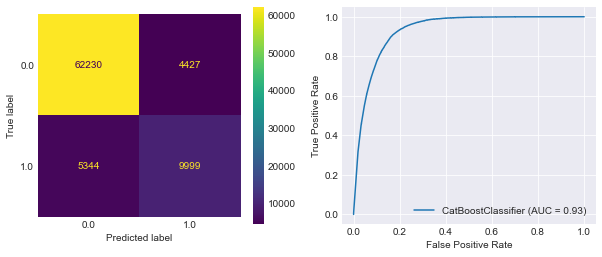

In [62]:
plot_graph(catm, xval, yval)

#### CV

In [82]:
crossVal(catm)

Fold 1: Logloss: 0.25307148516806727
Fold 2: Logloss: 0.251988481128665
Fold 3: Logloss: 0.2533965629861095
Fold 4: Logloss: 0.2521398830248521
Fold 5: Logloss: 0.2527115383380484
Avg Logloss: 0.25266159012914846


In [83]:
gc.collect()

20

In [84]:
cat_pred = crossValPred(catm)

Fold 1: Logloss: 0.25125230759570166
Fold 2: Logloss: 0.2524235163015819
Fold 3: Logloss: 0.2520917499575824
Fold 4: Logloss: 0.2530892336314724
Fold 5: Logloss: 0.2522065534517045
Avg Logloss: 0.2522126721876086


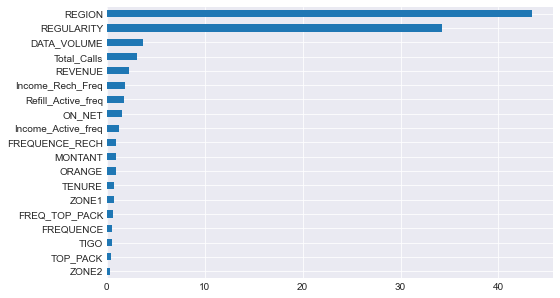

In [85]:
pd.Series(catm.feature_importances_, index=catm.feature_names_).sort_values().plot.barh(figsize=(8,5));

#### LGB

In [86]:
X[cat_cols] = X[cat_cols].astype('category')
test_c[cat_cols] = test_c[cat_cols].astype('category')

In [87]:
xtrainval, xtest, ytrainval, ytest = train_test_split(X, y, test_size=0.18, stratify=y, random_state=seed)
xtrain, xval, ytrain, yval = train_test_split(xtrainval, ytrainval, test_size=0.25, stratify=ytrainval, random_state=seed)

In [88]:
lgbm = lgb.LGBMClassifier(random_state=seed, n_estimators=1000, metric='binary_logloss', learning_rate=0.04, subsample=0.7,
                         colsample_bytree=0.8, num_leaves=64, reg_alpha=4, min_child_samples=5,subsample_freq=2)

In [73]:
lgbm.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xval,yval)], verbose=200, early_stopping_rounds=200);

Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.245082	valid_1's binary_logloss: 0.249841
[400]	training's binary_logloss: 0.238758	valid_1's binary_logloss: 0.25012
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.242893	valid_1's binary_logloss: 0.249795


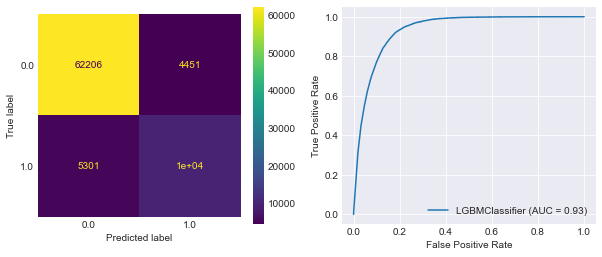

In [74]:
plot_graph(lgbm, xval, yval)

#### CV

In [89]:
crossVal(lgbm)

Fold 1: Logloss: 0.25307871704066154
Fold 2: Logloss: 0.2518664324403173
Fold 3: Logloss: 0.2535552092999488
Fold 4: Logloss: 0.25190849165036583
Fold 5: Logloss: 0.2528454713187494
Avg Logloss: 0.2526508643500086


In [90]:
gc.collect()

20

In [91]:
lgb_pred = crossValPred(lgbm)

Fold 1: Logloss: 0.2511611055314104
Fold 2: Logloss: 0.2525740541546433
Fold 3: Logloss: 0.2521570099379862
Fold 4: Logloss: 0.25295391231782244
Fold 5: Logloss: 0.2525333587873361
Avg Logloss: 0.2522758881458397


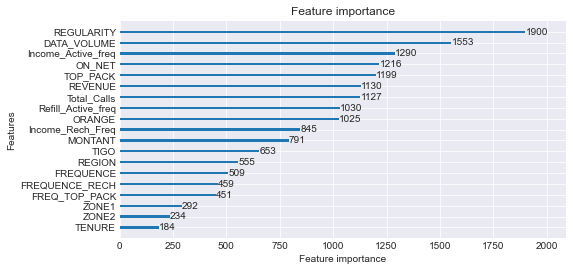

In [76]:
lgb.plot_importance(lgbm, figsize=(8,4), importance_type='split');

#### Submissions

In [92]:
blend = ((0.4 * lgb_pred + 0.6 * cat_pred) + (0.6 * lgb_pred + 0.4 * cat_pred))/2

In [93]:
lgb_df =  pd.DataFrame({'user_id' : test_id, 'CHURN' : lgb_pred})
cat_df =  pd.DataFrame({'user_id' : test_id, 'CHURN' : cat_pred})
blend_df =  pd.DataFrame({'user_id' : test_id, 'CHURN' : blend})

In [94]:
pd.DataFrame(np.c_[lgb_pred, cat_pred, blend], columns=['LGB', 'CAT', 'BLEND'])

,LGB,CAT,BLEND
0,0.781410,0.783321,0.782365
1,0.658634,0.657301,0.657967
2,0.109815,0.133594,0.121704
3,0.001442,0.000915,0.001178
4,0.000614,0.000220,0.000417
...,...,...,...
99995,0.001730,0.000907,0.001319
99996,0.006878,0.006759,0.006818
99997,0.039092,0.038501,0.038797
99998,0.007470,0.007723,0.007596


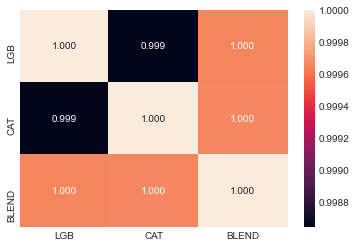

In [95]:
sns.heatmap(pd.DataFrame(np.c_[lgb_pred, cat_pred, blend], columns=['LGB', 'CAT', 'BLEND']).corr(), annot=True, fmt='.3f');

In [96]:
lgb_df.to_csv(path+'/predictions/lgb2a.csv', index=False)
cat_df.to_csv(path+'/predictions/cat2a.csv', index=False)
blend_df.to_csv(path+'/predictions/blend2a.csv', index=False)

In [97]:
gc.collect()

4070

Best Model: Blend
Private LB - 0.246702xxx

CAT (Private LB) - ~0.24697

LGB (Private LB) - ~0.24682